In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=53f6e7a21bd7b0ff546e8b5d025fdbc8556f31d1dfa025a4cb6a8a1c3601bc48
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#yahoo finance används för att hämta data
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


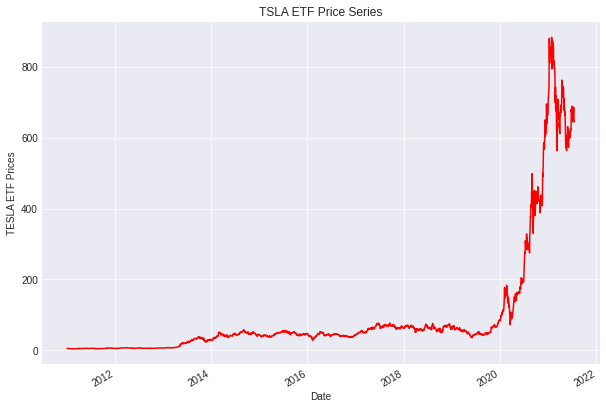

In [ ]:
# Läsa data
Df = yf.download('TSLA', '2011-01-01', '2021-7-18', auto_adjust=True)

# Håll bara nära kolumner
Df = Df[['Close']]

# Släpp rader med saknade värden
Df = Df.dropna()

# Plottera slutpris för TESLA
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("TESLA ETF Prices")
plt.title("TSLA ETF Price Series")
plt.show()

# New Section

**Define dependent variable**

In [ ]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']

**Split the data into train and test dataset**

In [ ]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

**Create a linear regression model**


In [ ]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("TESLA ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
TESLA ETF Price (y) = 1.19 * 3 Days Moving Average (x1) + -0.19 * 9 Days Moving Average (x2) + 0.15 (constant)


**Predict the TESLA ETF prices**

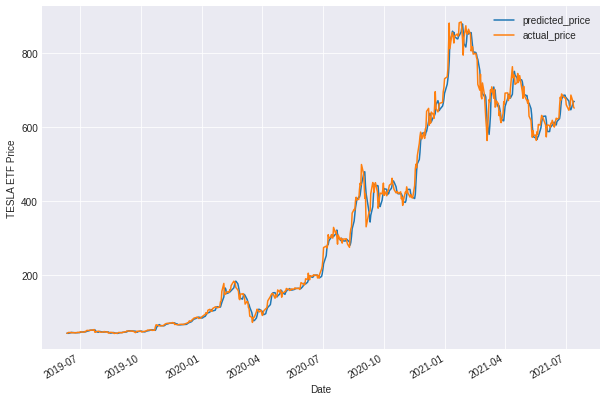

In [ ]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("TESLA ETF Price")
plt.show()

In [ ]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

99.44

**Plotting cumulative returns**

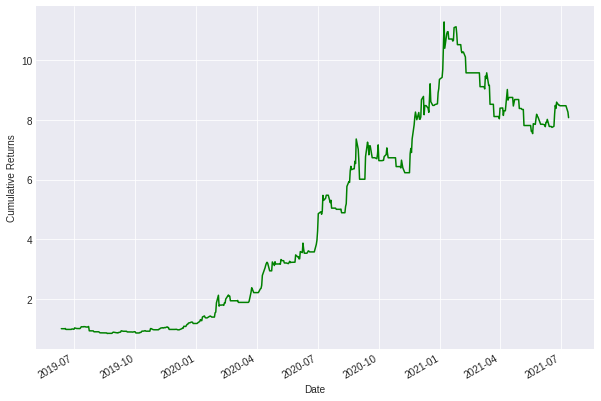

In [ ]:
tesla = pd.DataFrame()

tesla['price'] = Df[t:]['Close']
tesla['predicted_price_next_day'] = predicted_price
tesla['actual_price_next_day'] = y_test
tesla['tesla_returns'] = tesla['price'].pct_change().shift(-1)

tesla['signal'] = np.where(tesla.predicted_price_next_day.shift(1) < tesla.predicted_price_next_day,1,0)

tesla['strategy_returns'] = tesla.signal * tesla['tesla_returns']
((tesla['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

**Calculate the Sharpe ratio**

In [ ]:
# Calculate sharpe ratio
sharpe = tesla['strategy_returns'].mean()/tesla['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 2.16'

**Use the model to predict dialy move**

In [ ]:
import warnings
import datetime as dt

warnings.filterwarnings('ignore')

current_date = dt.datetime.now()

# Get the data
data = yf.download('TSLA', '2011-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_tesla_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_tesla_price.shift(1) < data.predicted_tesla_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_tesla_price']].T# import datetime and get today's date


[*********************100%***********************]  1 of 1 completed


Date,2021-07-20
signal,Buy
predicted_tesla_price,646.951
